<a href="https://colab.research.google.com/github/ShraddhaSharma24/Natural-Language-Processing/blob/main/LoRA_Based_Pruning_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  STEP 1: Install dependencies
!pip install transformers datasets evaluate

#  STEP 2: Import libs
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00


In [ ]:
# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# STEP 3: Load tokenizer, dataset
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_dataset("glue", "sst2")

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
# Metrics
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
#  Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_dir="./logs",
    report_to="none")

In [ ]:
# STEP 4: Define training + evaluation function
def train_and_evaluate(num_layers_to_keep):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    # Prune if necessary
    if num_layers_to_keep < 6:
        model.distilbert.transformer.layer = torch.nn.ModuleList(
            list(model.distilbert.transformer.layer[:num_layers_to_keep])
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"].select(range(2000)),     # small subset
        eval_dataset=dataset["validation"].select(range(500)),  # small subset
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_accuracy"]

In [ ]:
#  STEP 5: Run experiments for different pruning levels
layer_configs = [6, 5, 4, 3]  # 6 = unpruned, 3 = heavy pruning
results = {}

for layers in layer_configs:
    print(f"\n🔍 Evaluating model with {layers}/6 layers...")
    acc = train_and_evaluate(layers)
    results[layers] = acc
    print(f"✅ Accuracy with {layers} layers: {acc:.4f}")


🔍 Evaluating model with 6/6 layers...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


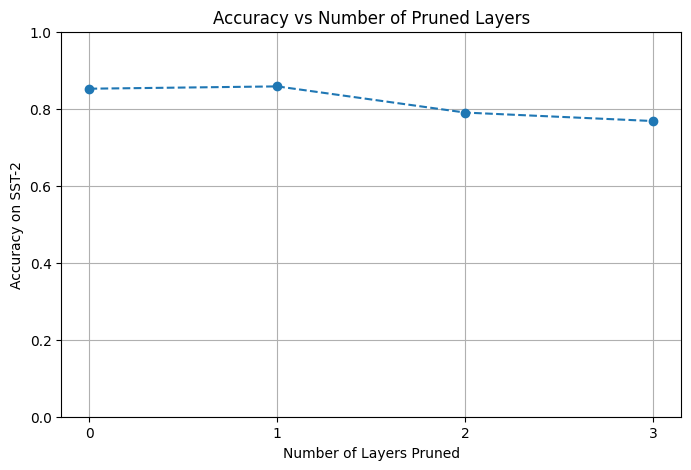

In [ ]:
# ✅ STEP 6: Plot the results
plt.figure(figsize=(8,5))
x = [6 - l for l in results.keys()]  # X = number of layers pruned
y = list(results.values())           # Y = accuracy

plt.plot(x, y, marker='o', linestyle='--')
plt.title("Accuracy vs Number of Pruned Layers")
plt.xlabel("Number of Layers Pruned")
plt.ylabel("Accuracy on SST-2")
plt.grid(True)
plt.xticks([0,1,2,3])
plt.ylim(0, 1)
plt.show()

Unstructured Pruning
1. BASED ON WEIGHTS

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch.nn.utils.prune as prune
import torch
import numpy as np

# Load pretrained model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model.eval()  # set to eval mode


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Find all linear layers in the model
linear_layers = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        linear_layers.append((name, module))

print(f"Total Linear Layers found: {len(linear_layers)}")


Total Linear Layers found: 38


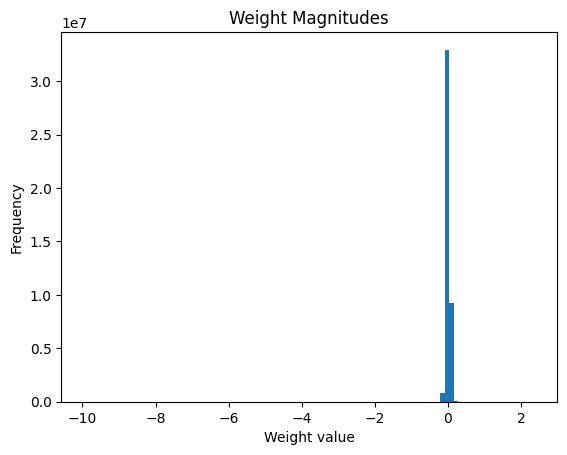

In [ ]:
import matplotlib.pyplot as plt

weights = [param.detach().cpu().numpy().flatten() for _, layer in linear_layers for param in [layer.weight]]
weights_flat = np.concatenate(weights)
plt.hist(weights_flat, bins=100)
plt.title("Weight Magnitudes")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Prune 40% of weights in each linear layer (unstructured)
for name, layer in linear_layers:
    prune.l1_unstructured(layer, name="weight", amount=0.4)


In [ ]:
for _, layer in linear_layers:
    prune.remove(layer, "weight")


NEURON PRUNING

In [ ]:
# Structured pruning by pruning 30% of output neurons (dim=0)
for name, layer in linear_layers:
    prune.ln_structured(layer, name="weight", amount=0.3, n=2, dim=0)

# Optional: finalize
for _, layer in linear_layers:
    prune.remove(layer, "weight")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import numpy as np


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(100, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = SimpleMLP()
print(model)


SimpleMLP(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
# Prune 50% of the weights in each layer (unstructured)
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.5)

# Check if pruning mask applied
print(model.fc1.weight)


tensor([[-0.0896, -0.0516,  0.0823,  ..., -0.0607,  0.0629, -0.0000],
        [ 0.0000,  0.0610, -0.0513,  ...,  0.0000, -0.0555, -0.0000],
        [ 0.0000, -0.0712, -0.0685,  ..., -0.0000,  0.0642, -0.0537],
        ...,
        [ 0.0590, -0.0000,  0.0830,  ..., -0.0518,  0.0000,  0.0582],
        [ 0.0689,  0.0745,  0.0000,  ..., -0.0742, -0.0611, -0.0000],
        [ 0.0554, -0.0810,  0.0931,  ..., -0.0000,  0.0754, -0.0555]],
       grad_fn=<MulBackward0>)


In [ ]:
# Prune 40% of the input neurons (structured by dimension 1)
prune.ln_structured(model.fc1, name="weight", amount=0.4, n=2, dim=1)

# Prune 30% of the output neurons (structured by dim 0)
prune.ln_structured(model.fc2, name="weight", amount=0.3, n=2, dim=0)


Linear(in_features=64, out_features=32, bias=True)

In [ ]:
class PrunedMLP(nn.Module):
    def __init__(self):
        super(PrunedMLP, self).__init__()
        self.fc1 = nn.Linear(100, 64)
        # self.fc2 = nn.Linear(64, 32)  ❌ removing this layer
        self.fc3 = nn.Linear(64, 10)  # directly connect fc1 → fc3

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x)) ❌ skipped
        return self.fc3(x)

pruned_model = PrunedMLP()


In [ ]:
def count_nonzero_params(model):
    total = 0
    nonzero = 0
    for p in model.parameters():
        total += p.numel()
        nonzero += torch.count_nonzero(p)
    return nonzero.item(), total, 100 * nonzero.item() / total

nz, total, pct = count_nonzero_params(model)
print(f"Non-zero Params: {nz}/{total} ({pct:.2f}%)")


Non-zero Params: 8874/8874 (100.00%)


In [ ]:
from transformers import BertModel
import torch.nn.utils.prune as prune

model = BertModel.from_pretrained("bert-base-uncased")

# Prune 20% of weights in the attention output layer
prune.l1_unstructured(model.encoder.layer[0].attention.output.dense, name='weight', amount=0.2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Linear(in_features=768, out_features=768, bias=True)

**LoRA-Based Pruning Evaluation**

In [1]:
!pip install transformers datasets evaluate peft accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import numpy as np
import evaluate
import os
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType

os.environ["WANDB_DISABLED"] = "true"

# Load dataset
dataset = load_dataset("glue", "sst2")
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [3]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Structured pruning: keep first 4 of 6 layers
model.distilbert.transformer.layer = torch.nn.ModuleList(
    list(model.distilbert.transformer.layer[:4])
)

print("✅ Layers after pruning:", len(model.distilbert.transformer.layer))


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Layers after pruning: 4


In [4]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
model = get_peft_model(model, lora_config)


In [5]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./pruned-lora",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_steps=10,
    do_eval=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"].select(range(2000)),
    eval_dataset=dataset["validation"].select(range(500)),
    compute_metrics=compute_metrics
)

trainer.train()
results_pruned_lora = trainer.evaluate()
print("✅ Accuracy after pruning + LoRA:", results_pruned_lora["eval_accuracy"])


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.688100
20,0.683900
30,0.682900
40,0.669000
50,0.671800
60,0.681100
70,0.665500
80,0.678600
90,0.667800
100,0.662000


✅ Accuracy after pruning + LoRA: 0.618


 LoRA-Based Pruning Evaluation Loop

In [ ]:
#  Install everything needed
!pip install transformers datasets evaluate peft accelerate

# Imports
import os
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType

os.environ["WANDB_DISABLED"] = "true"

# Load SST-2 dataset and tokenize
dataset = load_dataset("glue", "sst2")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Accuracy metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# Training config
training_args = TrainingArguments(
    output_dir="./tmp-pruning-loop",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # 👈 deeper fine-tuning
    logging_steps=10,
    do_eval=True,
    report_to="none"
)

# Function: Prune → Apply LoRA → Fine-tune → Evaluate
def run_experiment(keep_layers):
    # Load fresh model
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    # Apply pruning
    if keep_layers < 6:
        model.distilbert.transformer.layer = torch.nn.ModuleList(
            list(model.distilbert.transformer.layer[:keep_layers])
        )

    # Apply LoRA
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_lin", "v_lin"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    model = get_peft_model(model, lora_config)

    # Set up trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"].select(range(8000)),    # 👈 more data
        eval_dataset=dataset["validation"].select(range(500)),
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_accuracy"]

# Run experiments: unpruned, prune 1 layer, prune 2 layers
layer_configs = [6, 5, 4]
results = {}

for keep in layer_configs:
    print(f"\n🔍 Running with {keep}/6 layers...")
    acc = run_experiment(keep)
    results[keep] = acc
    print(f"✅ Accuracy with {keep} layers: {acc:.4f}")

# Plot results
plt.figure(figsize=(8,5))
x = [6 - l for l in results.keys()]  # x = # layers pruned
y = list(results.values())

plt.plot(x, y, marker='o', linestyle='--', color='purple')
plt.xticks([0, 1, 2])
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Accuracy on SST-2")
plt.title("📉 Accuracy vs Pruned Layers (w/ LoRA Recovery)")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

# ✅ Print summary
print("\n📊 Summary:")
for k, v in results.items():
    print(f"  - Layers kept: {k} → Accuracy: {v:.4f}")


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 Running with 6/6 layers...


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.687700
